In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import pickle  # Pour sauvegarder l'état de PCAx

# Matplotlib settings
from matplotlib import rcParams

# Scikit-learn modules
import pcax 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# Keras (deep learning)
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, BatchNormalization
from keras.optimizers import Adam
from keras.losses import MeanSquaredError, Huber, MeanAbsoluteError
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l1, l2, l1_l2
from pathlib import Path

# again, this only works on startup!
import jax
jax.config.update("jax_enable_x64", True)

2025-04-01 15:38:49.716334: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# 📌 Scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# 📌 TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras import Model, Input, Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


data_path = Path("/Users/xifumacbook/Documents/Codes/Spectres/apec/apec_simon_approved.npz")
data = np.load(data_path)

spectres = data["simulations"]  # shape (n_samples, n_bins)
theta = data["theta"]           # shape (n_samples, n_params)

theta = np.delete(theta, [1, 2, -1], axis=1)

print(f"Theta shape : {theta.shape}")
print(f"Spectres shape : {spectres.shape}")

# 📌 Transformation log1p sur les spectres
spectres = np.log1p(spectres)

# 📌 Normalisation
scaler_spectre = MinMaxScaler()
spectres_scaled = scaler_spectre.fit_transform(spectres)

# 📌 Définition de l'autoencodeur style TBNN
def build_autoencoder(input_dim, latent_dim, learning_rate=1e-4):
    # Encoder
    encoder = Sequential([
        Dense(256, activation='gelu', input_shape=(input_dim,)),
        Dense(256, activation='gelu'),
        Dense(256, activation='gelu'),
        #Dense(256, activation='gelu'),
        Dense(latent_dim, activation='linear', name='latent_space')
    ])

    # Decoder
    decoder = Sequential([
        Dense(256, activation='gelu', input_shape=(latent_dim,)),
        Dense(256, activation='gelu'),
        Dense(256, activation='gelu'),
        #Dense(256, activation='gelu'),
        Dense(input_dim, activation='linear')
    ])

    # Assemble Autoencoder
    inputs = Input(shape=(input_dim,))
    latent = encoder(inputs)
    outputs = decoder(latent)

    autoencoder = Model(inputs, outputs)
    autoencoder.compile(optimizer=Adam(learning_rate=learning_rate), loss=Huber(delta=5.5))

    return autoencoder, encoder, decoder

# 📌 Instanciation
input_dim = spectres_scaled.shape[1]
latent_dim = 20
autoencoder, encoder, decoder = build_autoencoder(input_dim, latent_dim)

autoencoder.summary()

# 📌 Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-5, verbose=1)

# 📌 Entraînement
history = autoencoder.fit(
    spectres_scaled, spectres_scaled,
    validation_split=0.1,
    epochs=300,
    batch_size=256,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# 📌 Plot de la loss
def plot_loss(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Huber Loss')
    plt.yscale('log')
    plt.legend()
    plt.show()

plot_loss(history)

Loading APEC data...
Theta shape : (50000, 1)
Spectres shape : (50000, 10000)


/Users/xifumacbook/miniforge3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 10000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 20)             │     2,762,772 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 10000)          │     2,772,752 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,535,524 (21.12 MB)

 Trainable params: 5,535,524 (21.12 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
704/704 - 41s - 58ms/step - loss: 0.0099 - val_loss: 2.2876e-04 - learning_rate: 1.0000e-04
Epoch 2/300
704/704 - 41s - 58ms/step - loss: 1.1795e-04 - val_loss: 8.2441e-05 - learning_rate: 1.0000e-04
Epoch 3/300
704/704 - 40s - 56ms/step - loss: 4.7903e-05 - val_loss: 2.5607e-05 - learning_rate: 1.0000e-04
Epoch 4/300
704/704 - 44s - 63ms/step - loss: 2.6496e-05 - val_loss: 1.7010e-05 - learning_rate: 1.0000e-04
Epoch 5/300
704/704 - 45s - 64ms/step - loss: 2.2665e-05 - val_loss: 1.2080e-05 - learning_rate: 1.0000e-04
Epoch 6/300
704/704 - 46s - 65ms/step - loss: 1.9344e-05 - val_loss: 1.2801e-05 - learning_rate: 1.0000e-04
Epoch 7/300
704/704 - 48s - 68ms/step - loss: 1.6286e-05 - val_loss: 1.1784e-05 - learning_rate: 1.0000e-04
Epoch 8/300
704/704 - 45s - 65ms/step - loss: 1.7859e-05 - val_loss: 1.2497e-05 - learning_rate: 1.0000e-04
Epoch 9/300

Epoch 9: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
704/704 - 50s - 71ms/step - loss: 1.1201e-05 - val_

KeyboardInterrupt: 

In [ ]:
# 📌 Reconstruction directe par l'autoencodeur
def reconstruct_spectra(autoencoder, scaler_spectre, spectrum_scaled_sample):
    """
    Reconstruit un spectre depuis son entrée dans l'autoencodeur (scaled)
    """
    # Passage dans l'autoencodeur
    reconstructed_scaled = autoencoder.predict(spectrum_scaled_sample.reshape(1, -1))
    # Annulation du scaling + log1p
    y_log = scaler_spectre.inverse_transform(reconstructed_scaled)
    return np.expm1(y_log).flatten()

# 📌 Plot d'un échantillon autoencodeur
def plot_sample(idx):
    """
    📌 Plot la reconstruction et l'erreur relative d'un spectre APEC
    via l'autoencodeur, à partir de son indice uniquement.
    """
    # 📌 Prise du spectre normalisé (scaled) à l'indice donné
    spectrum_scaled_sample = spectres_scaled[idx]

    # 📌 Reconstruction par l'autoencodeur
    reconstructed_scaled = autoencoder.predict(spectrum_scaled_sample.reshape(1, -1))
    spectrum_pred_orig = np.expm1(scaler_spectre.inverse_transform(reconstructed_scaled)).flatten()

    # 📌 Vérité terrain
    spectrum_true_orig = np.expm1(scaler_spectre.inverse_transform(spectrum_scaled_sample.reshape(1, -1))).flatten()

    # 📌 Calcul erreur relative bin à bin
    eps = 1e-8
    error_bin = (spectrum_true_orig - spectrum_pred_orig) / (np.abs(spectrum_true_orig) + eps) * 100
    global_error = 100 * np.linalg.norm(spectrum_true_orig - spectrum_pred_orig) / np.linalg.norm(spectrum_true_orig)

    print(f"✅ Sample {idx} | Relative global error : {global_error:.3f}%")

    # 📌 Échelle d'énergie (logarithmique)
    e_min, e_max, num_bins = 0.1, 50, spectrum_true_orig.shape[0]
    energy_array = np.geomspace(e_min, e_max, num_bins)

    # 📌 Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

    # ✅ Spectres
    ax1.semilogx(energy_array, spectrum_pred_orig, label='Reconstructed', color='blue')
    ax1.semilogx(energy_array, spectrum_true_orig, label='Original', color='red', linestyle='dashed')
    ax1.set_xlabel("Energy (keV)")
    ax1.set_ylabel("Intensity")
    ax1.legend()
    ax1.set_title(f"Autoencoder - Sample {idx}", fontsize=10)

    # ✅ Erreur relative
    ax2.plot(energy_array, error_bin, color='red', label='Relative error (%)')
    ax2.fill_between(energy_array, 0, error_bin, color='red', alpha=0.3)
    ax2.set_xlabel("Energy (keV)")
    ax2.set_ylabel("Error (%)")
    ax2.legend()

    plt.tight_layout()
    plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
✅ Sample 69 | Relative global error : 7.966%


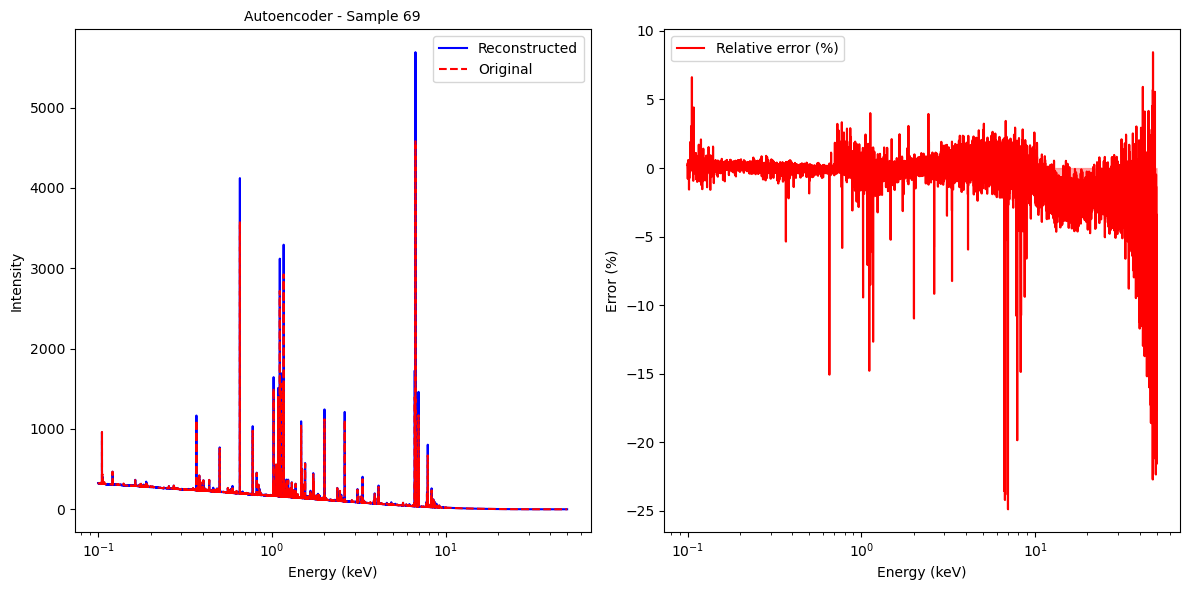

In [ ]:
plot_sample(69)

In [ ]:
def plot_global_errors_per_theta_autoencoder(autoencoder, spectres_scaled, theta, scaler_spectre, custom_legends=None):
    """
    Trace l'erreur globale par spectre en fonction des paramètres theta pour l'autoencodeur APEC.
    """
    eps = 1e-8

    # Reconstruction directe
    spectres_reconstructed = autoencoder.predict(spectres_scaled)

    # Remise dans l'échelle physique
    spectres_orig = np.expm1(scaler_spectre.inverse_transform(spectres_scaled))
    spectres_reconstructed = np.expm1(scaler_spectre.inverse_transform(spectres_reconstructed))

    # Calcul des erreurs globales en norme L2
    global_errors = np.array([
        100 * np.linalg.norm(true - pred) / (np.linalg.norm(true) + eps)
        for true, pred in zip(spectres_orig, spectres_reconstructed)
    ])

    print(f"\nNombre total de spectres : {len(global_errors)}")
    print(f"Erreur globale moyenne : {np.mean(global_errors):.3f}%")

    # Trouver les spectres > 3%
    high_error_indices = np.where(global_errors > 5)[0]
    print(f"\nNombre de spectres avec erreur > 5% : {len(high_error_indices)}")

    # Plot des erreurs par paramètre
    plt.figure(figsize=(15, 10))
    theta_names = [r"$kT_s$"]

    for i, param_name in enumerate(theta_names):
        plt.subplot(2, 3, i + 1)
        plt.scatter(theta[:, i], global_errors, color='dodgerblue', alpha=0.7, edgecolor='black', s=40)

        # Légendes personnalisées si fournies
        xlabel = custom_legends[param_name]["xlabel"] if custom_legends and param_name in custom_legends else param_name
        plt.xlabel(xlabel)
        plt.ylabel("Global Error (%)")

    plt.tight_layout()
    plt.show()

    return high_error_indices

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step

Nombre total de spectres : 50000
Erreur globale moyenne : 4.802%

Nombre de spectres avec erreur > 3% : 32281


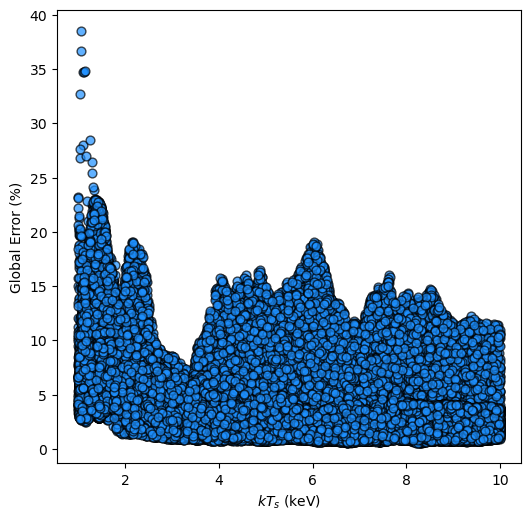

Indices des spectres > 3% d'erreur : [    0     4     5 ... 49994 49996 49998]


In [ ]:
custom_legends = {
    r"$kT_s$": {"xlabel": r"$kT_s$ (keV)"},
}

high_error_indices = plot_global_errors_per_theta_autoencoder(
    autoencoder=autoencoder,
    spectres_scaled=spectres_scaled,
    theta=theta,
    scaler_spectre=scaler_spectre,
    custom_legends=custom_legends
)

print(f"Indices des spectres > 3% d'erreur : {high_error_indices}")
